<a href="https://colab.research.google.com/github/sohamthirty/Stock-Price-Prediction-with-Sentiment-Analysis/blob/main/Financial_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
#!pip install requests
# !pip install bs4
#!pip install python-decouple
#!pip install langdetect

#!pip install vaderSentiment

#nltk.download('vader_lexicon')
#nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [49]:
import pandas as pd
import requests as req
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
df_analytics = pd.read_csv("analyst_ratings_processed.csv", encoding='UTF-8')
df_analytics['stock'] = df_analytics['stock'].replace(['GOOG', 'GOOGL'], 'GOOGL')
# df_analyst_rating = pd.read_csv("raw_analyst_ratings.csv", encoding = 'UTF-8')
# df_partner_headlines= pd.read_csv("raw_partner_headlines.csv", encoding = 'UTF-8')

In [141]:
## Entire dataset
num_rows_df_analytics = len(df_analytics)
print("Number of rows in the df_analytics:", num_rows_df_analytics)
print(df_analytics['stock'].nunique())
# num_rows_df_analyst_rating = len(df_analyst_rating)
# print("Number of rows in the df_analyst_rating:", num_rows_df_analyst_rating)

# num_rows_df_partner_headlines = len(df_partner_headlines)
# print("Number of rows in the df_partner_headlines:", num_rows_df_partner_headlines)

Number of rows in the df_analytics: 796658
5842


In [5]:
def filter_dataframe (df):
  startdate = pd.to_datetime("2015-01-01").date()
  enddate = pd.to_datetime("2020-12-31").date()
  df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
  df['date'] = df['date'].dt.date
  df = df.loc[(df['date'] >= startdate) & (df['date'] <= enddate)]
  return df

In [6]:
df_analytics = filter_dataframe(df_analytics)
# df_analyst_rating = filter_dataframe(df_analyst_rating)
# df_partner_headlines = filter_dataframe(df_partner_headlines)

In [7]:
def get_statistics(df):
  num_rows = len(df)
  print("Total Number of rows in the df_analyst_rating from 2015-2020:", num_rows)
  categories_to_check = ['AAPL', 'GOOG','GOOGL', 'AMZN', 'MSFT','TSLA']
  filtered_df = df[df['stock'].isin(categories_to_check)]
  print("unique tickers : ", filtered_df['stock'].unique())
  print(filtered_df["stock"].value_counts())
  filtered_df['year'] = pd.DatetimeIndex(filtered_df['date']).year
  yearly_counts = filtered_df.groupby('year').size()
  print("\n")
  print("Yearly Counts")
  print(yearly_counts)
  return filtered_df

In [8]:
filtered_analytics  = get_statistics(df_analytics)

filtered_analytics.tail()

Total Number of rows in the df_analyst_rating from 2015-2020: 796658
unique tickers :  ['AAPL' 'AMZN' 'GOOGL' 'TSLA']
GOOGL    2794
TSLA     1930
AAPL      469
AMZN      330
Name: stock, dtype: int64


Yearly Counts
year
2018     343
2019    2210
2020    2970
dtype: int64


,Unnamed: 0,title,date,stock,year
1250207,1263065.0,Electrek.Co Tweet: Tesla's head of Europe is out,2019-07-02,TSLA,2019
1250208,1263066.0,Tesla's Q2 Delivery Number Could Cause A Big Move,2019-07-01,TSLA,2019
1250209,1263067.0,'Tesla Electric Airplane? Elon Musk sees elect...,2019-07-01,TSLA,2019
1250210,1263068.0,"UPDATE: JMP Reiterates Outperform, $347 Target...",2019-07-01,TSLA,2019
1250211,1263069.0,Tesla shares are trading higher after JMP Secu...,2019-07-01,TSLA,2019


In [9]:
filtered_analytics.columns

Index(['Unnamed: 0', 'title', 'date', 'stock', 'year'], dtype='object')

In [10]:
# filtered_ratings = get_statistics(df_analyst_rating)
# filtered_ratings.head()

In [11]:
# filtered_headlines  = get_statistics(df_partner_headlines)
# filtered_headlines.head()

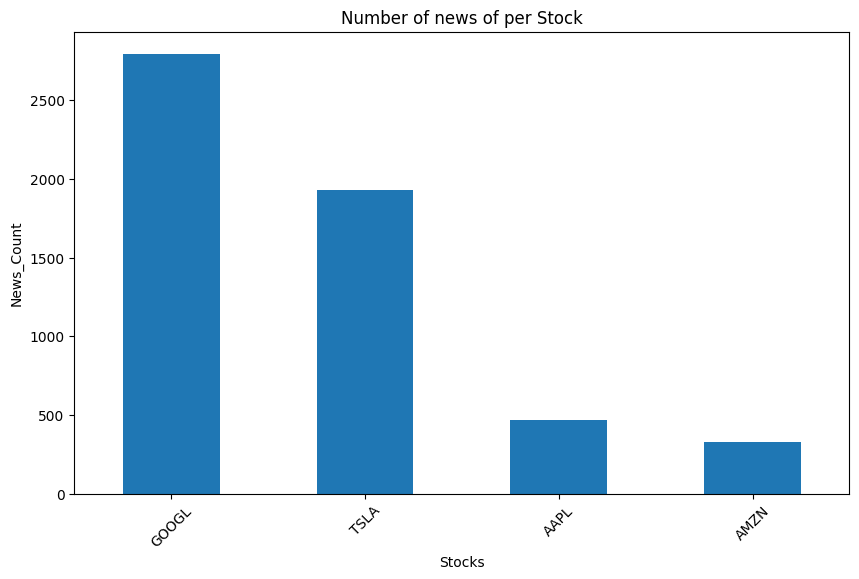

In [12]:
# Plot a bar chart
stock_counts = filtered_analytics["stock"].value_counts()
plt.figure(figsize=(10, 6))
stock_counts.plot(kind='bar')
plt.xlabel('Stocks')
plt.ylabel('News_Count')
plt.title('Number of news of per Stock')
plt.xticks(rotation=45)
plt.show()

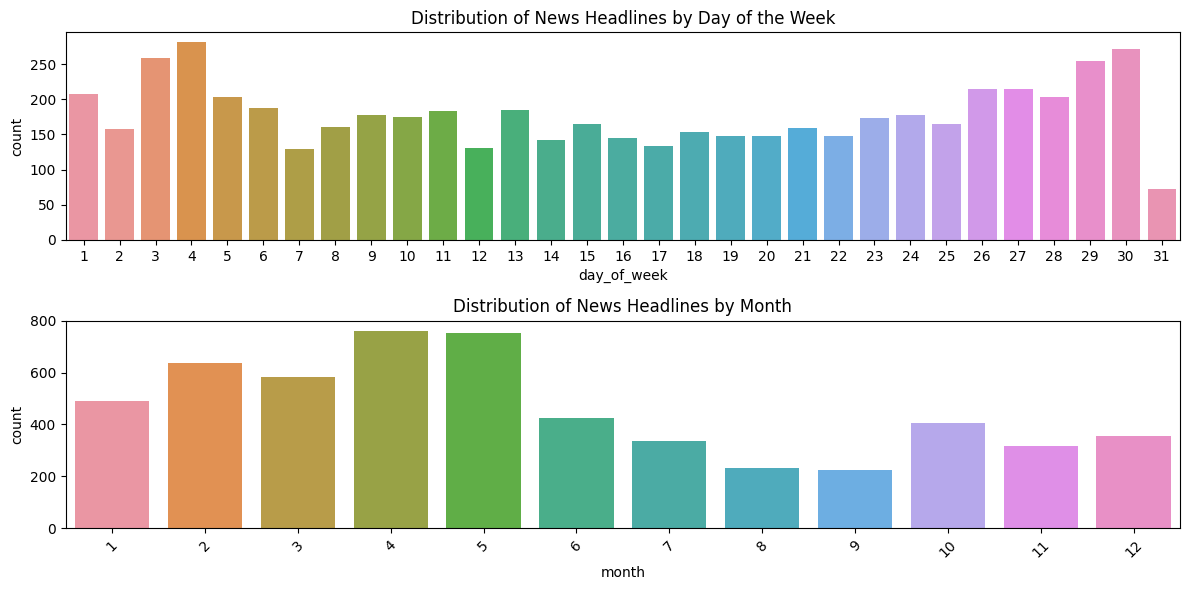

In [13]:
# Extract features from the date column
filtered_analytics['day_of_week'] = pd.DatetimeIndex(filtered_analytics['date']).day  # Extract day of the week
filtered_analytics['month'] = pd.DatetimeIndex(filtered_analytics['date']).month    # Extract month
filtered_analytics['year'] = pd.DatetimeIndex(filtered_analytics['date']).year

# Analyze the distribution of news headlines based on day of the week and month
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.countplot(x='day_of_week', data=filtered_analytics)
plt.title('Distribution of News Headlines by Day of the Week')

plt.subplot(2, 1, 2)
sns.countplot(x='month', data=filtered_analytics)
plt.title('Distribution of News Headlines by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# # plt.subplot(2, 1, 3)
# sns.countplot(x='year', data=df_analytics)
# plt.title('Distribution of News Headlines by Year')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# yearly_counts = df_analytics.groupby('year').size()
# plt.figure(figsize=(10, 6))
# yearly_counts.plot(kind='bar',color='#FFD580')
# plt.xlabel('Years')
# plt.ylabel('News_count')
# plt.title('Number of news of per year')
# plt.xticks(rotation=45)
# plt.show()

#, order=df_analytics['day_of_week'].value_counts().index
#, order=df_analytics['month'].value_counts().index

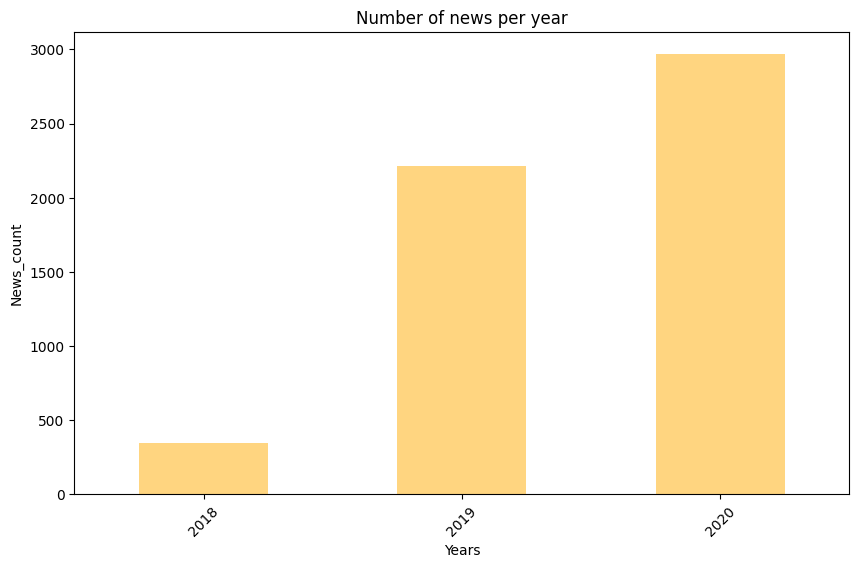

In [14]:
filtered_analytics['year'] = pd.DatetimeIndex(filtered_analytics['date']).year
yearly_counts = filtered_analytics.groupby('year').size()
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar',color='#FFD580')
plt.xlabel('Years')
plt.ylabel('News_count')
plt.title('Number of news per year')
plt.xticks(rotation=45)
plt.show()

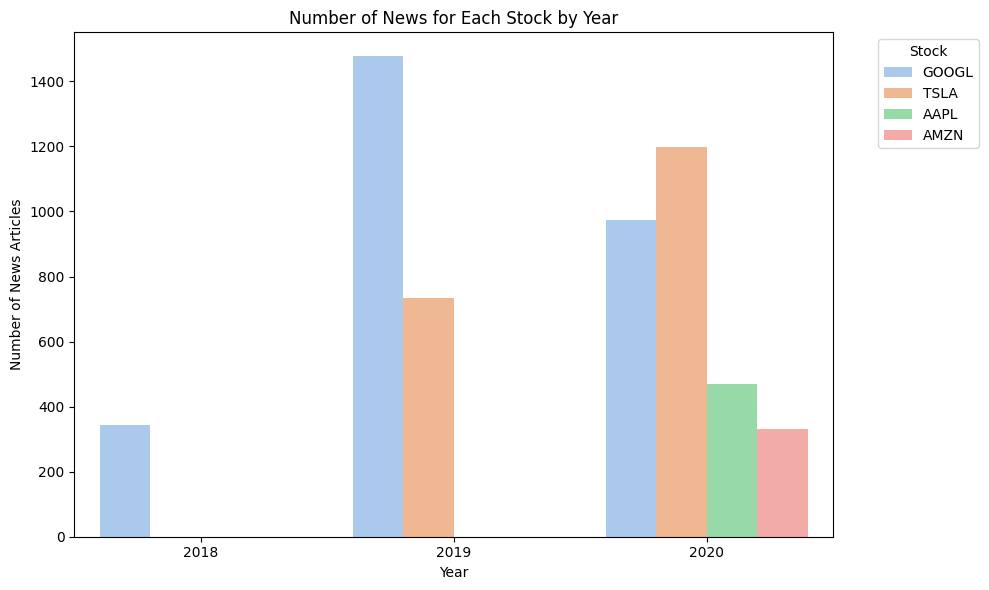

In [15]:
yearly_stock_counts = filtered_analytics.groupby(['year', 'stock']).size().reset_index(name='count')
colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_stock_counts, x='year', y='count', hue='stock', palette=colors)
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.title('Number of News for Each Stock by Year')
plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

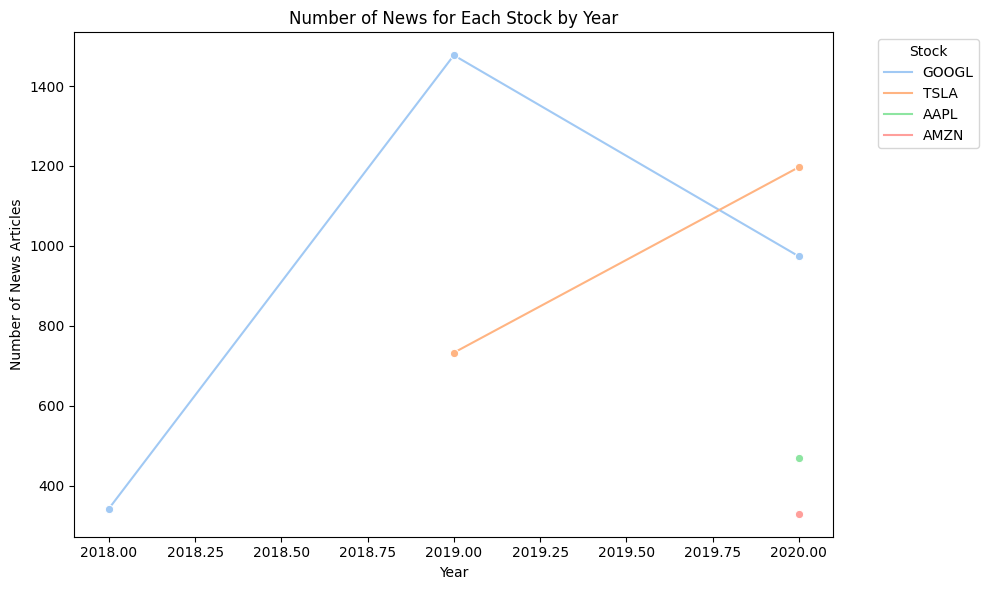

In [16]:
yearly_stock_counts = filtered_analytics.groupby(['year', 'stock']).size().reset_index(name='count')
colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_stock_counts, x='year', y='count', hue='stock', palette=colors, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.title('Number of News for Each Stock by Year')
plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [137]:
def plot_wordcloud(df, ticker_name, col):

  category = ticker_name

  # Filter DataFrame for the specific category
  filtered_cat = df[df['stock'] == category]
  text = ' '.join(filtered_cat[col])

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  # Plot the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for "{category}" Stock')
  plt.show()

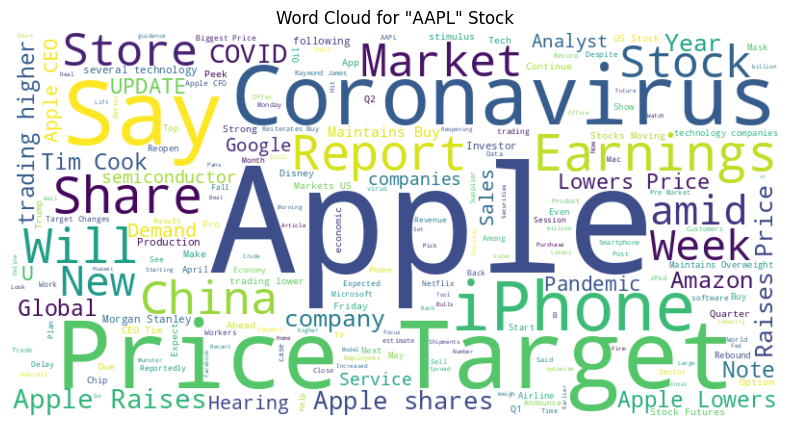

In [138]:
plot_wordcloud(filtered_analytics, "AAPL",'title')

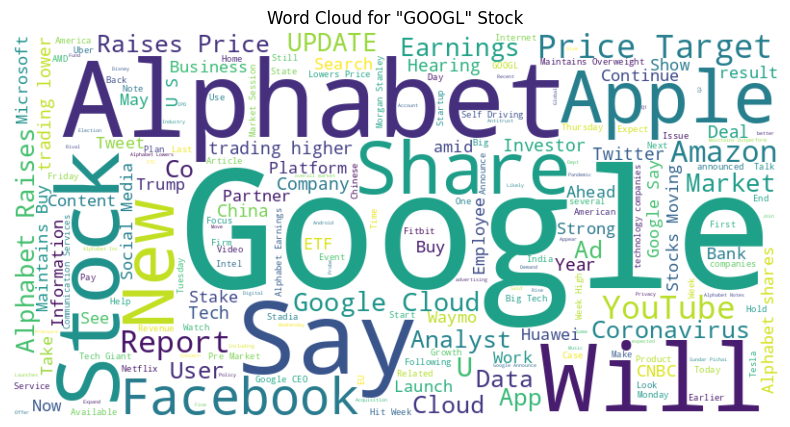

In [133]:
plot_wordcloud("GOOGL")

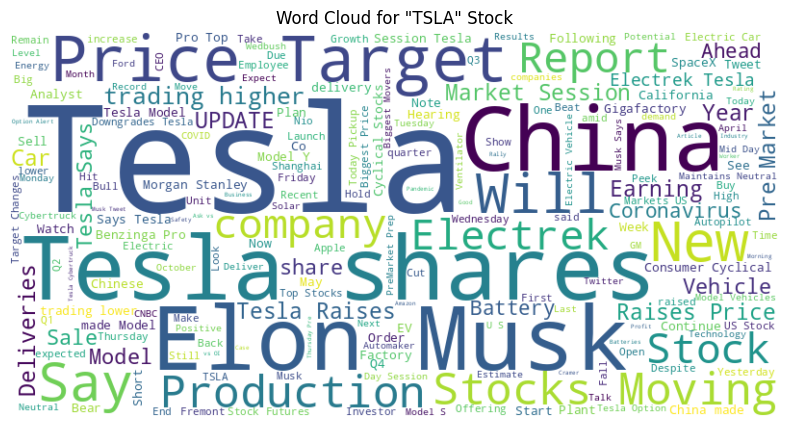

In [134]:
plot_wordcloud("TSLA")

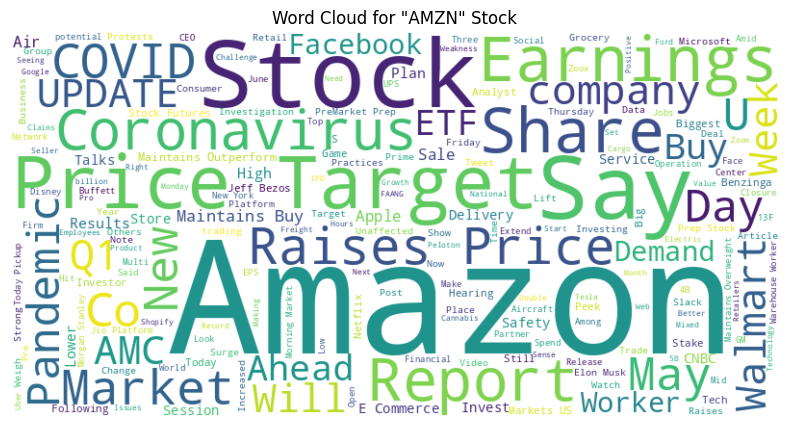

In [135]:
plot_wordcloud("AMZN")

In [22]:
# Check if every date has atleast 1 tweet
def check_tweets_for_each_ticker(df):
    date_ticker_counts = df.groupby(['date', 'stock'])['title'].nunique()

    # Check if any combination of 'post_date' and 'ticker_symbol' has a count less than 1
    dates_missing_tweets = date_ticker_counts[date_ticker_counts < 1]

    if dates_missing_tweets.empty:
        print("All dates have at least one news for every ticker_symbol.")
    else:
        print("The following dates do not have at least one tweet for every ticker_symbol:")
        print(dates_missing_tweets)

check_tweets_for_each_ticker(filtered_analytics)


All dates have at least one news for every ticker_symbol.


In [23]:
filtered_analytics.columns

Index(['Unnamed: 0', 'title', 'date', 'stock', 'year', 'day_of_week', 'month'], dtype='object')

In [27]:
# DataFrame with all unique dates from 2018-01-01 to 2020-12-31
all_dates = pd.date_range(start='2018-01-01', end='2020-12-31', freq='D')
unique_dates_df = pd.DataFrame(all_dates, columns=['date'])
unique_dates_df = filter_dataframe(unique_dates_df)

# Get unique stock tickers from filtered_dataframe
unique_tickers = filtered_analytics['stock'].unique()

# Create an empty DataFrame to store the results
missing_news_dates = pd.DataFrame(columns=['date', 'stock'])

# Iterate through each stock ticker and check for missing news dates
for ticker in unique_tickers:
    # Create a temporary DataFrame for the current stock ticker
    temp_df = unique_dates_df.copy()
    temp_df['stock'] = ticker

    # Left join with filtered_dataframe on 'date' and 'stock'
    merged_df = pd.merge(temp_df, filtered_analytics, on=['date', 'stock'], how='left')

    # Check for missing news (NaN values)
    missing_news = merged_df[merged_df['title'].isnull()]

    # If there are missing news dates, append them to the result DataFrame
    if not missing_news.empty:
        missing_news_dates = pd.concat([missing_news_dates, missing_news[['date', 'stock']]])


print("Dates with missing news for each stock ticker:")
missing_news_dates['year'] = pd.DatetimeIndex(missing_news_dates['date']).year
missing_news_dates

Dates with missing news for each stock ticker:


,date,stock,year
0,2018-01-01,AAPL,2018
1,2018-01-02,AAPL,2018
2,2018-01-03,AAPL,2018
3,2018-01-04,AAPL,2018
4,2018-01-05,AAPL,2018
...,...,...,...
2736,2020-12-27,TSLA,2020
2737,2020-12-28,TSLA,2020
2738,2020-12-29,TSLA,2020
2739,2020-12-30,TSLA,2020


Number of missing dates for each stock ticker:
stock
AAPL     1013
AMZN     1055
GOOGL     615
TSLA      811
Name: date, dtype: int64


In [142]:
# Group by 'stock' column and count the number of missing dates for each stock ticker
missing_dates_count = missing_news_dates.groupby('stock')['date'].count()

print("Number of missing dates for each stock ticker:")
print(missing_dates_count)

# number of missing dates for each stock per year from 2018-2020
missing_per_year_count = missing_news_dates.groupby(['stock','year'])['date'].count()

print("Number of missing dates per year for each stock ticker:\n",)

print(missing_per_year_count)

Number of missing dates for each stock ticker:
stock
AAPL     1013
AMZN     1055
GOOGL     615
TSLA      811
Name: date, dtype: int64
Number of missing dates per year for each stock ticker:

stock  year
AAPL   2018    365
       2019    365
       2020    283
AMZN   2018    365
       2019    365
       2020    325
GOOGL  2018    259
       2019    111
       2020    245
TSLA   2018    365
       2019    222
       2020    224
Name: date, dtype: int64


## VADER sentiment On Raw Titles

In [143]:
def perform_sentiment_analysis(df, col):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis for each 'text' in the DataFrame
    sentiment_scores = df[col].apply(lambda x: sia.polarity_scores(x))

     # Extract the 'compound' value from each dictionary in the Series
    compound_scores = sentiment_scores.apply(lambda x: x['compound'])

    # Map the compound scores to sentiment labels
    sentiment_labels = compound_scores.apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')

    # Add sentiment labels to the DataFrame
    df['VADER_sentiment'] = sentiment_labels
    df['compound_score'] = compound_scores

    return df

In [144]:
# function call
df_news = perform_sentiment_analysis(filtered_analytics,'title')

In [149]:
def get_sentiment_stats(df, sentiment_label):
    sentiment_rows = df[df['VADER_sentiment'] == sentiment_label]
    maximum_score = sentiment_rows['compound_score'].max()
    news_count = len(sentiment_rows)
    print("Maximum", sentiment_label, "Score: ", maximum_score)
    print("Number of", sentiment_label, "news: ", news_count,  "\n")
    return sentiment_rows

negative_sentiment_rows = get_sentiment_stats(df_news, 'Negative')
neutral_sentiment_rows = get_sentiment_stats(df_news, 'Neutral')
positive_sentiment_rows = get_sentiment_stats(df_news, 'Positive')


Maximum Negative Score:  -0.0516
Number of Negative news:  946 

Maximum Neutral Score:  0.049
Number of Neutral news:  2635 

Maximum Positive Score:  0.9477
Number of Positive news:  1942 



In [148]:
negative_sentiment_rows

,title,date,stock,year,day_of_week,month,VADER_sentiment,compound_score,clean_title
3695,"US Debt Market Raised $22.5B This Week, The Hi...",2020-06-05,AAPL,2020,5,6,Negative,-0.3612,u debt market raised 225b week highest since 2...
3703,"Zoom Initially Slips Despite Strong Earnings, ...",2020-06-03,AAPL,2020,3,6,Negative,-0.4023,zoom initially slip despite strong earnings re...
3704,"Morgan Stanley Maintains Overweight on Apple, ...",2020-06-03,AAPL,2020,3,6,Negative,-0.3612,morgan stanley maintains overweight apple rais...
3707,'Apple is tracking iPhones stolen by looters' ...,2020-06-02,AAPL,2020,2,6,Negative,-0.4939,apple tracking iphones stolen looter earlier n...
3709,Hearing Susquehanna Check Suggests Total iPhon...,2020-06-02,AAPL,2020,2,6,Negative,-0.1280,hearing susquehanna check suggests total iphon...
...,...,...,...,...,...,...,...,...,...
1250172,'Tesla Autopilot team loses several more engin...,2019-07-09,TSLA,2019,9,7,Negative,-0.3182,tesla autopilot team loses several engineer el...
1250174,'Frustrated Musk Shakes Up Autopilot Team' -Th...,2019-07-09,TSLA,2019,9,7,Negative,-0.5267,frustrated musk shake autopilot team information
1250201,'Tesla Sales Could Boom in China as Local Comp...,2019-07-02,TSLA,2019,2,7,Negative,-0.1779,tesla sale could boom china local competitor l...
1250206,'Tesla loses engineering VP amid end-of-quarte...,2019-07-02,TSLA,2019,2,7,Negative,-0.3182,tesla loses engineering vp amid endofquarter d...


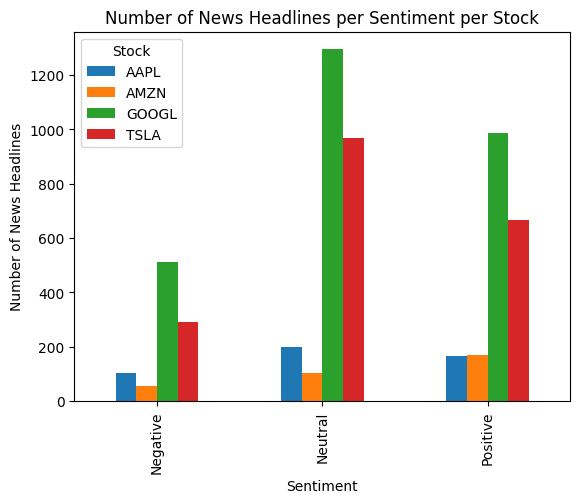

In [113]:
# Group by 'VADER_sentiment' and 'Stock' and count the number of News Headlines
news_counts = df_news.groupby(['VADER_sentiment', 'stock']).size().unstack(fill_value=0)

# Create the side-by-side bar graph
ax = news_counts.plot(kind='bar', stacked=False)
plt.xlabel('Sentiment')
plt.ylabel('Number of News Headlines')
plt.title('Number of News Headlines per Sentiment per Stock')
plt.legend(title='Stock', loc='upper left')
plt.show()

 # Vader sentiment on Cleaned Titles

In [120]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_news(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase and tokenize
    words = text.lower().split()

    # Remove stop words, lemmatize, and stem
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # words = [stemmer.stem(word) for word in words]

    # Join the words back into a clean text
    clean_text = ' '.join(words)

    return clean_text

In [123]:
# apply clean function and create new column
filtered_analytics['clean_title'] = filtered_analytics['title'].apply(clean_news)

In [128]:
# function call
df_news_cleaned = perform_sentiment_analysis(filtered_analytics,'clean_title')

In [129]:
negative_max_score, negative_news_count = get_sentiment_stats(df_news_cleaned, 'Negative')
neutral_max_score, neutral_news_count = get_sentiment_stats(df_news_cleaned, 'Neutral')
positive_max_score, positive_news_count = get_sentiment_stats(df_news_cleaned, 'Positive')

print("Maximum Negative Score:", negative_max_score)
print("Number of Negative news:", negative_news_count, "\n")

print("Maximum Neutral Score:", neutral_max_score)
print("Number of Neutral news:", neutral_news_count, "\n")

print("Maximum Positive Score:", positive_max_score)
print("Number of Positive news:", positive_news_count, "\n")


Maximum Negative Score: -0.0077
Number of Negative news: 939 

Maximum Neutral Score: 0.0
Number of Neutral news: 2519 

Maximum Positive Score: 0.9559
Number of Positive news: 2065 



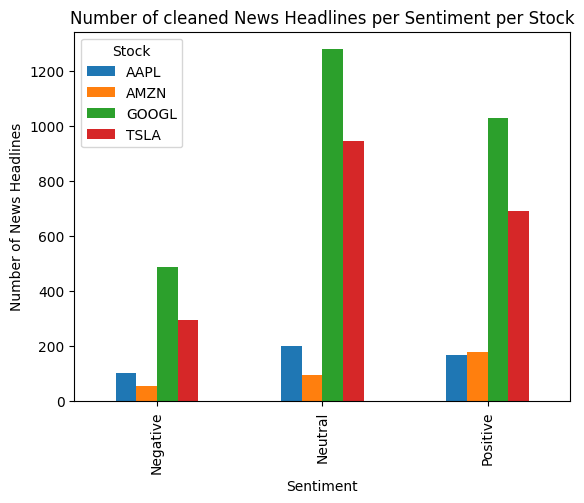

In [131]:
# Group by 'VADER_sentiment' and 'Stock' and count the number of News Headlines
news_counts = df_news_cleaned.groupby(['VADER_sentiment', 'stock']).size().unstack(fill_value=0)

# Create the side-by-side bar graph
ax = news_counts.plot(kind='bar', stacked=False)
plt.xlabel('Sentiment')
plt.ylabel('Number of News Headlines')
plt.title('Number of cleaned News Headlines per Sentiment per Stock')
plt.legend(title='Stock', loc='upper left')
plt.show()